<a href="https://colab.research.google.com/github/zahraDehghanian97/Brain_cancer_classification/blob/master/Brain_Tumor_MRI_Image_Classification_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Detection and Classification of Brain Tumor through Brain MRI Images Using Deep Learning**  

## **1.Introduction**  

* The occurrence of brain tumor patients in India is steadily rising,
more and more number of cases are reported each year in India across
various age groups.  

* The [International Association of Cancer Registries (IARC)](https://cutt.ly/Wc4DaIE) reported
that there are over $28,000$ cases of brain tumours reported in India
each year and more than $24,000$ people reportedly i.e. $85.72\%$ of the
total reported die due to brain tumours annually. Brain tumour’s are
a serious condition and in most cases fatal if not detected & treated
in early stages.



## **2. Setting Up Local Storage for Dataset**

### **2.1 Giving Access To Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **3. Importing Required Libraries**

In [39]:
import sys
import os
import math
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
 
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.9.2.


### **4.3 Setting Up Paths to Root and Data Directories**

In [4]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer')
!ls
     

#Create a directory named dataset
!mkdir dataset
!ls -a

data.zip
dataset  data.zip


In [ ]:
#Download Files
from google.colab import files
import requests 
file_url = "https://ndownloader.figshare.com/articles/1512427/versions/5"
	
r = requests.get(file_url, stream = True) 

with open("/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/data.zip", "wb") as file: 
	for block in r.iter_content(chunk_size = 1024): 
		if block: 
			file.write(block) 


In [5]:

##Unzip data
!unzip -q data.zip -d dataset/


In [12]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1-766.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_767-1532.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_1533-2298.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/dataset/brainTumorDataPublic_2299-3064.zip', 'r') as zip_ref:
   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/Training')


In [15]:
def mat_file_to_dict(filepath: str) -> dict:
    tumor_class = {1: 'meningioma', 2: 'glioma', 3: 'pituitary_tumor'}
    tumor_data_dict = {}
    with h5py.File(filepath, mode = 'r') as image_data:
        cjdata_struct = image_data['cjdata']
        id  = ""
        for i in range (len(cjdata_struct['PID'])):
          id = id+str(cjdata_struct['PID'][i][0])
        tumor_data_dict['PID'] = int(id)
        tumor_data_dict['class'] = tumor_class[int(cjdata_struct['label'][0, 0])]
        tumor_data_dict['image'] = (cjdata_struct['image'][:].transpose())
        tumor_data_dict['tumor_border'] = cjdata_struct['tumorBorder'][0]
        tumor_data_dict['tumor_mask'] = cjdata_struct['tumorMask'][:].transpose()
    return tumor_data_dict

In [24]:
!mkdir CleanData
!ls
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Brain Cancer/CleanData')
!mkdir meningioma
!mkdir glioma
!mkdir pituitary_tumor
!ls


glioma	meningioma  pituitary_tumor


In [25]:
rootpath_dataset = '/content/gdrive/My Drive/Colab Notebooks/Brain Cancer'
mat_dirname = os.path.join(rootpath_dataset,'Training')
training_dir = os.path.join(rootpath_dataset, 'CleanData')
m_path = os.path.join(training_dir, 'meningioma')
g_path = os.path.join(training_dir, 'glioma')
p_path = os.path.join(training_dir, 'pituitary_tumor')
data = []
m_count, g_count, p_count = (0, 0, 0)
for root, dirpath, filenames in os.walk(mat_dirname):
    for curr_file in filenames :
        mri_img_data = mat_file_to_dict(os.path.join(root, curr_file))
        data.append(mri_img_data)
        tumor_class = mri_img_data['class']
        id = mri_img_data['PID']
        if tumor_class == 'meningioma':
            m_count += 1
            plt.savefig(os.path.join(m_path, f'M{m_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'glioma':
            g_count += 1
            plt.savefig(os.path.join(g_path, f'G{g_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        elif tumor_class == 'pituitary_tumor':
            p_count += 1
            plt.savefig(os.path.join(p_path, f'P{p_count}_{id}.jpg'), dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        else:
            pass
df_images = pd.DataFrame(data)

<Figure size 432x288 with 0 Axes>

## **5. Data Preprocessing and Exploratory Data Analysis**

In [31]:
ROOT_DIR = r'/content/gdrive/MyDrive/Colab Notebooks/Brain Cancer/'
TRAIN_DIR = os.path.join(ROOT_DIR, 'CleanData')
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

In [32]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
dtype: int64

### **5.1 Data Distribution Visualization**

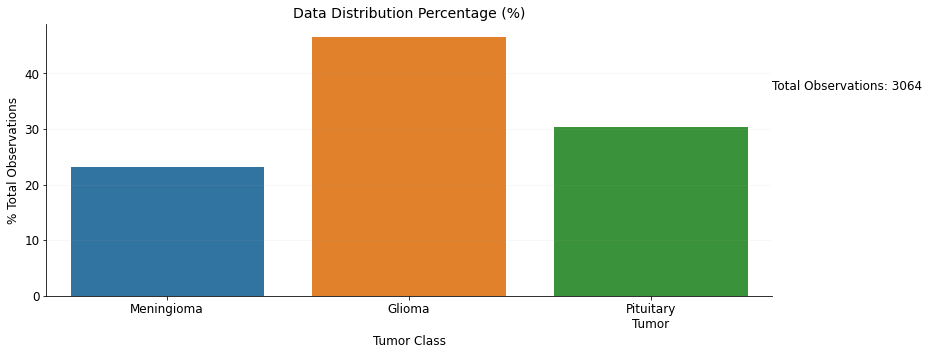

In [33]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

### **5.2 Visualisation of Brain MRI Dataset**

**Dataset Source: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427**  

**Source Code for Conversion of `.mat` file to `.jpg`: [Google Colab Notebook Link](https://colab.research.google.com/drive/1aucu3Ipj1eS0y1YEzKq76Z38TaetHSc3?usp=sharing)**  

**Final Dataset Link: https://drive.google.com/drive/folders/11QIC82FBdAyq0PUwLVNd22i-oq6lcat1?usp=sharing**

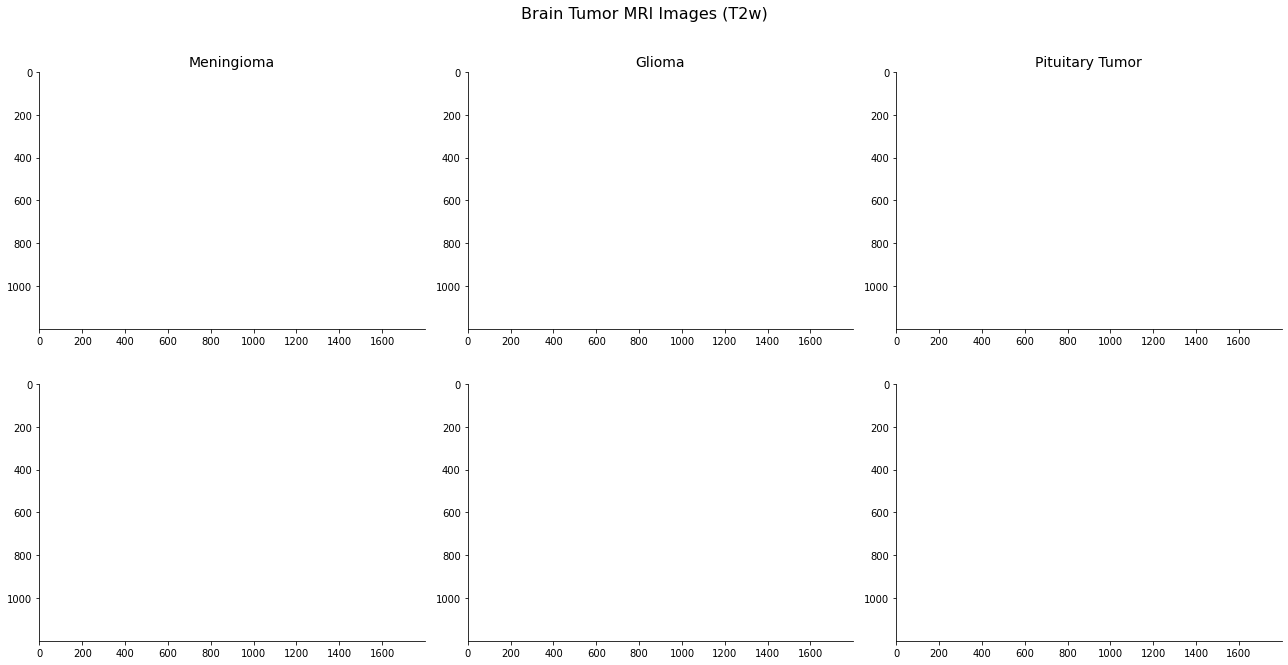

In [49]:
import matplotlib.image as mpimg

BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS, IMAGE_DATA_PATHS, axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[0]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR),cmap = 'gray')
    # curr_axis.imshow(mpimg.imread(os.path.join(filename, os.listdir(filename)[0])),cmap = 'gray')
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

for filename, curr_axis in zip(IMAGE_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[1]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR),cmap = 'gray')
    # curr_axis.imshow(mpimg.imread(os.path.join(filename, os.listdir(filename)[0])),cmap = 'gray')

fig.tight_layout()
sns.despine()

### **6. Development of Training, Validation & Testing Dataset**

In [50]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [51]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
1,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,meningioma
2,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
3,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma
4,/content/gdrive/MyDrive/Colab Notebooks/Brain ...,glioma


In [52]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3064 non-null   object
 1   tumor_class      3064 non-null   object
dtypes: object(2)
memory usage: 48.0+ KB


In [53]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.tumor_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.tumor_class)

### **6.1 Training, Validation and Testing Dataset Data Distribution Visualization**

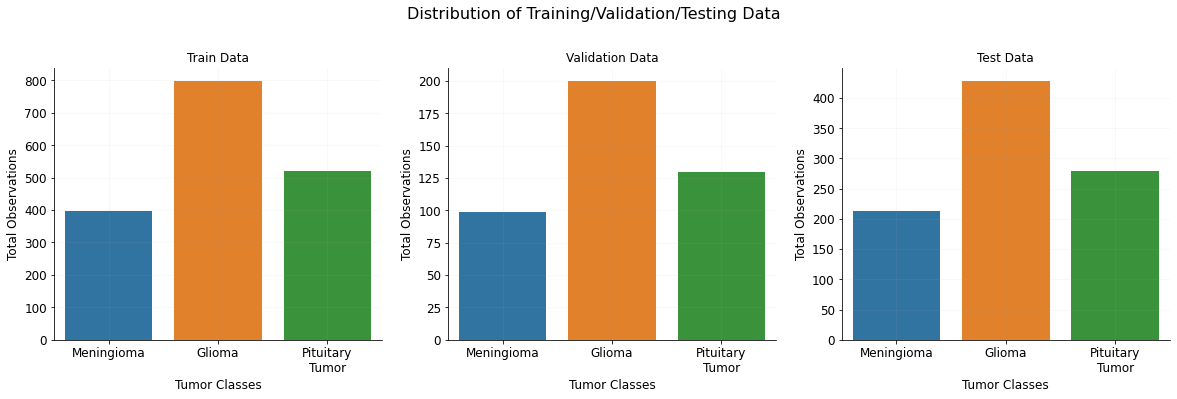

In [54]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()

## **7. Data/Image Augmentation**
* Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness. 

* We will use data/image augmentation using `ImageDataGenerator` class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.

In [55]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

In [56]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [57]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1715 validated image filenames belonging to 3 classes.
Found 429 validated image filenames belonging to 3 classes.
Found 920 validated image filenames belonging to 3 classes.


## **8. Model Development**

In [59]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [62]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()

In [71]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['Loss', 'Accuracy','Precison','Recall', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [ curr_model_loss, curr_model_accuracy,precision_score(y_hat, y_preds, average = "micro"),recall_score(y_hat, y_preds, average = "micro"), f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

### **8.1 ResNet**

#### **8.1.1 Developement of ResNet**

In [ ]:
# base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
# for layer in base_model.layers:
#   layer.trainable = False
# x = layers.Flatten()(base_model.output)
# x = layers.Dense(1000, activation='relu')(x)
# predictions = layers.Dense(10, activation = 'softmax')(x)
# head_model = Model(inputs = base_model.input, outputs = predictions)
# head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])
# history = head_model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
resnet_model = ResNet50(weights = 'imagenet',include_top = False, 
                                 input_shape = (image_size, image_size, 3))
resnet_model.trainable = False

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
resnet_cnn_model = Sequential()
resnet_cnn_model.add(inception_v3_model)
resnet_cnn_model.add(Flatten())
resnet_cnn_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-1'))
resnet_cnn_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer'))
resnet_cnn_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
resnet_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
Hidden-Layer-1 (Dense)       (None, 1024)              2098176   
_________________________________________________________________
Output-Layer (Dense)         (None, 4)                 4100      
Total params: 23,905,060
Trainable params: 2,102,276
Non-trainable params: 21,802,784
_________________________________________________________________


#### **8.1.2 Training and Validation of Resnet Model**

In [ ]:
inception_model_train_history = resnet_cnn_model.fit(train_dataset, 
                                                            batch_size = batch_size,
                                                            validation_data = validation_dataset, 
                                                            epochs = 200, 
                                                            callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 83s 1s/step - loss: 1.8779 - accuracy: 0.6012 - val_loss: 0.7379 - val_accuracy: 0.7113

Epoch 00001: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 2/100
61/61 [==============================] - 76s 1s/step - loss: 0.6863 - accuracy: 0.7335 - val_loss: 0.6218 - val_accuracy: 0.7979

Epoch 00002: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 3/100
61/61 [==============================] - 76s 1s/step - loss: 0.6144 - accuracy: 0.7670 - val_loss: 0.6042 - val_accuracy: 0.7835

Epoch 00003: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 4/100
61/61 [==============================] - 76s 1s/step - loss: 0.5593 - accuracy: 0.7774 - val_loss: 0.8480 - val_accuracy: 0.6536

Epoch 00004: saving model to gdrive/MyDrive/Deep_Learning_Course_Project/Model-Checkpoints/InceptionV3
Epoch 5/100
61/61 [=

#### **8.1.3 ResNet Model Training Process Statistics**

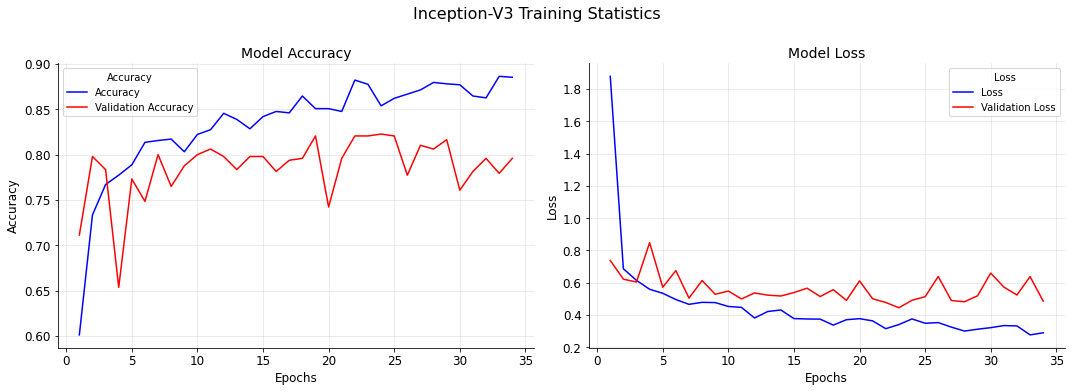

In [ ]:
training_process_viz(pd.DataFrame(resnet_model_train_history.history), 
                     plot_title = 'ResNet Training Statistics')

In [ ]:
resnet_report_df = generate_report(resnet_cnn_model, test_dataset = test_dataset, row_indexes = ['ResNet'])
resnet_report_df

33/33 [==============================] - 32s 962ms/step - loss: 0.4522 - accuracy: 0.8256


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
InceptionV3,1.365125,3.101156,1.76101,0.452249,0.825626,0.2842


### **8.2 AlexNet CNN**

#### **8.2.1 Develoment of AlexNet CNN Model**

In [74]:
alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(3, activation = 'softmax', name = 'Output-Layer'))
alexnet_cnn.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
alexnet_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 30, 30, 96)        34944     
                                                                 
 Batch-Normalization-1 (Batc  (None, 30, 30, 96)       384       
 hNormalization)                                                 
                                                                 
 Max-Pooling-1 (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 Batch-Normalization-2 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                      

#### **8.2.2 Training and Validation of AlexNet CNN Model**

In [ ]:
alexnet_train_history = alexnet_cnn.fit(train_dataset, 
                                            batch_size = batch_size,
                                            validation_data = validation_dataset, 
                                            epochs = 100, 
                                            callbacks = [early_stopping])

Epoch 1/100
54/54 [==============================] - 65s 1s/step - loss: 1.9640 - accuracy: 0.3720 - val_loss: 3.7406 - val_accuracy: 0.3147
Epoch 2/100
54/54 [==============================] - 54s 998ms/step - loss: 1.2756 - accuracy: 0.3749 - val_loss: 1.0970 - val_accuracy: 0.4499
Epoch 3/100
54/54 [==============================] - 54s 1s/step - loss: 1.1679 - accuracy: 0.4029 - val_loss: 1.0631 - val_accuracy: 0.4662
Epoch 4/100
54/54 [==============================] - 55s 1s/step - loss: 1.1430 - accuracy: 0.4058 - val_loss: 1.0695 - val_accuracy: 0.3613
Epoch 5/100
54/54 [==============================] - 53s 984ms/step - loss: 1.1029 - accuracy: 0.4315 - val_loss: 1.0673 - val_accuracy: 0.4662
Epoch 6/100
54/54 [==============================] - 55s 1s/step - loss: 1.0870 - accuracy: 0.4536 - val_loss: 1.0639 - val_accuracy: 0.4662
Epoch 7/100
12/54 [=====>........................] - ETA: 36s - loss: 1.0809 - accuracy: 0.4818

#### **8.2.3 AlexNet CNN Model Training Process Statistics**

In [ ]:
training_process_viz(pd.DataFrame(alexnet_train_history.history), plot_title = 'AlexNet CNN Training Stats')

In [ ]:
alexnet_report_df = generate_report(alexnet_cnn, test_dataset = test_dataset, row_indexes = ['AlexNet CNN'])
alexnet_report_df

### **8.3 Multi-Layer Perceptron**

#### **8.3.1 Development of Multi-Layer Perceptron Model**

In [ ]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(3, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)              

#### **8.3.2 Training and Validation of Multi-Layer Perceptron Based Model**

In [ ]:
mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100, 
                                      callbacks = [early_stopping])

Epoch 1/100
54/54 [==============================] - 100s 1000ms/step - loss: 14.5093 - accuracy: 0.3662 - val_loss: 1.0968 - val_accuracy: 0.3030
Epoch 2/100
54/54 [==============================] - 55s 1s/step - loss: 1.1451 - accuracy: 0.4117 - val_loss: 1.0660 - val_accuracy: 0.4662
Epoch 3/100
54/54 [==============================] - 53s 993ms/step - loss: 1.0956 - accuracy: 0.4344 - val_loss: 1.0906 - val_accuracy: 0.4662
Epoch 4/100
54/54 [==============================] - 55s 1s/step - loss: 1.0682 - accuracy: 0.4653 - val_loss: 1.0561 - val_accuracy: 0.4662
Epoch 5/100
54/54 [==============================] - 53s 981ms/step - loss: 1.0578 - accuracy: 0.4653 - val_loss: 1.0560 - val_accuracy: 0.4662
Epoch 6/100
54/54 [==============================] - 55s 1s/step - loss: 1.0578 - accuracy: 0.4653 - val_loss: 1.0560 - val_accuracy: 0.4662
Epoch 7/100
54/54 [==============================] - 53s 985ms/step - loss: 1.0570 - accuracy: 0.4653 - val_loss: 1.0560 - val_accuracy: 0.466

#### **8.3.3 Multi-Layer Perceptron Based Model Training Process Statistics**

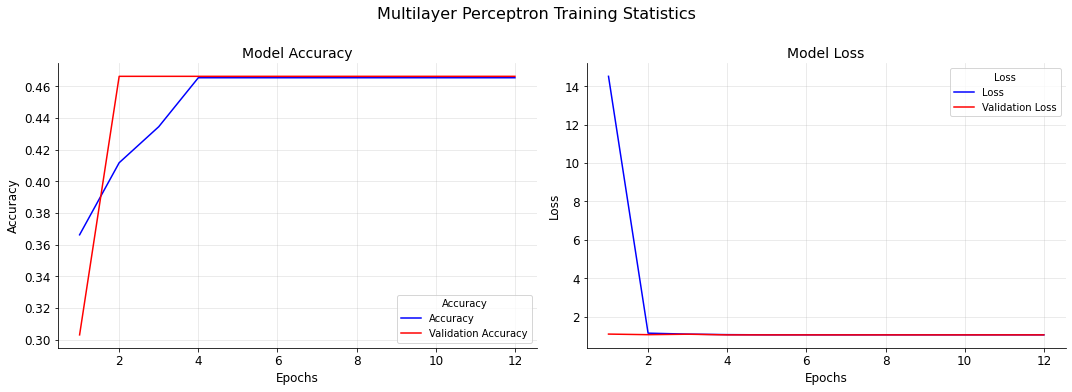

In [ ]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')

In [ ]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = test_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

29/29 [==============================] - 22s 764ms/step


,Loss,Accuracy,Precison,Recall,F1-Score
Multi-Layer-Perceptron Model,1.056622,0.465217,0.465217,0.465217,0.465217


## **9. Conclusions**

* The **pre-trained (imagenet) ResNet** model has performed the best among Multi-Layer perceptron and AlexNet CNN models with an accuracy of $82.57\%$ 

In [ ]:
final_report_df = pd.concat([mlp_report_df, alexnet_report_df, resnet_report_df])
final_report_df

,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.394990,3.533719,1.879819,0.926313,0.624277,0.368979
AlexNet CNN,1.301541,3.205202,1.790308,1.135692,0.607900,0.382466
InceptionV3,1.365125,3.101156,1.761010,0.452249,0.825626,0.284200
